In [3]:
import pandas as pd

read data

In [4]:
df_rain = pd.read_csv("./data/chennai-monthly-rains.csv")
df_flood = pd.read_csv("./data/chennai-monthly-manual-flood.csv")

clean data

In [5]:
X = df_rain.drop(columns=['Total'])
y = df_flood[(df_flood.year <= 2021)]

In [6]:
import matplotlib.pyplot as plt

visualise data

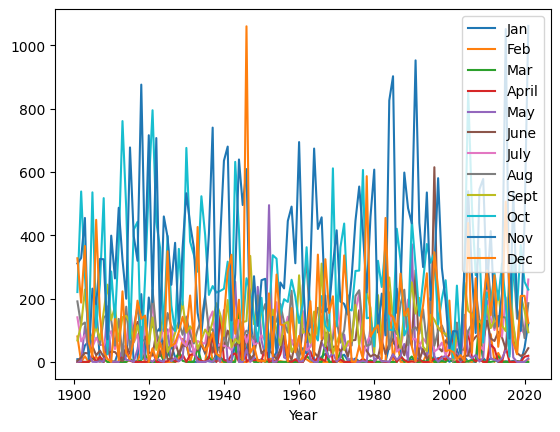

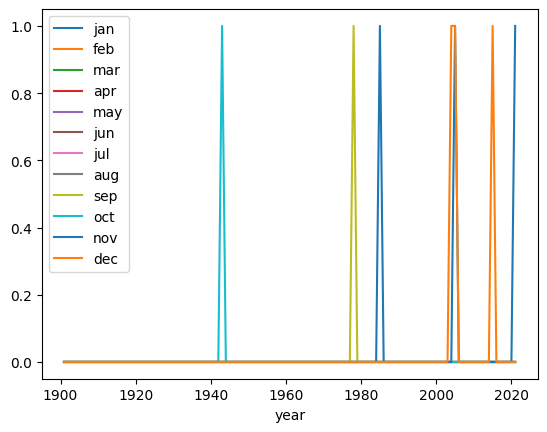

In [7]:
X.plot(x="Year")
y.plot(x="year")
plt.show()

# TODO: should data be balanced here? How can mostly false (0) be balanced?

In [8]:
from sklearn.model_selection import train_test_split

data splitting

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

train-validation split

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size=0.1, random_state=42)

# TODO: normalise data here